sentiment analysis over time

volume of tweets

do group comparison of the first three days versus all other days of the convention. Then shift the window one day and analyze again. Over and over throughout the convention. 

maybe display the top five words by index throughout the convention. 


###  Issues to address

deal with carriage returns

tab-separator

deal with hashtags separators

### Import packages / setup

In [ ]:
import numpy as np
import pandas as pd
import os
import sqlite3
from nltk.corpus import stopwords
sw2 = stopwords.words("english")
from string import punctuation
punctuation = set(punctuation)
punctuation.add("’")
import datetime
import time
from random import sample
import random

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,LdaMulticore, Phrases 
from gensim.models.phrases import Phraser 
from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.gensim_models

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from pprint import pprint
from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

Lemmatizer = nlp.get_pipe("lemmatizer")

In [1]:
import datetime
import tweepy
from tweepy import OAuthHandler
import json
import pandas as pd
import csv
import re
import string
import os
import time
import random
import numpy as np
from nltk.corpus import stopwords
sw = stopwords.words('english')
from string import punctuation
from collections import Counter, defaultdict
from pprint import pprint
from operator import itemgetter
import matplotlib.pyplot as plt


# I've put my API keys in a .py file called API_keys.py
from my_api_keys import api_key, api_key_secret, access_token, access_token_secret

In [2]:
# Authenticate the Tweepy API
auth = tweepy.OAuthHandler(api_key,api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [3]:
# Modifications to punctuation and sw lists

punctuation = set(punctuation)
punctuation.add("’")

sw2 = set(sw)
addl = ("|","-","/","•","&", "&amp;")
sw2.update(addl)

####  Read daily tweets CSVs into pandas dataframe

In [4]:
db = pd.DataFrame(columns = ['user_id','screen_name','description','location','friends_count',
           'followers_count','totaltweets','date_created', 'tweet_id', 'retweetcount','full_text'])

file_location = "/Users/natebender/Desktop/Repo/text-mining/datashare_AA_COP_tweets/data/"
files = sorted(os.listdir(file_location))
for idx, file in enumerate(files):
    
    data = "".join([file_location,file])
    datafile = pd.read_csv(data)

    db = db.append(datafile,ignore_index=True)

In [5]:
# Check desc stats on overall descriptions before splitting into groups
def get_patterns(all_tweets) :

    all_desc = all_tweets.dropna()
    all_str = " ".join(all_desc)    
    clean = [w for w in all_str.split() if w.lower() not in sw2]
    
    # Calculate your statistics here
    total_tokens = len(clean)
    unique_tokens = len(set(clean))
    clean_tok_len = [len(w) for w in clean]
    avg_token_len = np.mean(clean_tok_len)
    lex_diversity = len(set(clean))/len(clean)
    top_n = Counter(clean).most_common(20)
    
    
    # Now we'll fill out the dictionary. 
    results = {'tokens':total_tokens,
               'unique_tokens':unique_tokens,
               'avg_token_length':round(avg_token_len,2),
               'lexical_diversity':round(lex_diversity,2),
               'Top_n':top_n}

    return(results)

### Desc stats on database

In [6]:
# Drop NA values from description column
all_tweets = db.full_text.dropna()
print(f'Database: {"{:,}".format(len(db.tweet_id))} tweets')
#print(f'Date range: {db.date_created.min()} to {db.date_created.max()}')
print(f'Descriptive stats are:')
get_patterns(all_tweets)

Database: 285,084 tweets
Descriptive stats are:


{'tokens': 5523996,
 'unique_tokens': 170153,
 'avg_token_length': 7.82,
 'lexical_diversity': 0.03,
 'Top_n': [('#COP26', 227147),
  ('climate', 57446),
  ('#COP26Glasgow', 24133),
  ('world', 20434),
  ('#cop26', 18871),
  ('need', 18435),
  ('fossil', 17574),
  ('change', 15756),
  ('#Unknown', 15720),
  ('leaders', 14933),
  ('people', 13392),
  ('#ClimateAction', 13153),
  ('Climate', 12960),
  ('Glasgow', 12833),
  ('global', 11994),
  ('action', 11760),
  ('#ClimateCrisis', 11448),
  ('#COP26.', 10836),
  ('us', 10811),
  ('like', 10464)]}

### Lexicon expansion function to analyze tweets by time series window

In [93]:
# Subset dataframe to multiple 3-day windows

w1_text = db.full_text[(db['date_created']>= "2021-10-28") & (db['date_created']< "2021-10-29")]
w2_text = db.full_text[(db['date_created']>= "2021-10-29") & (db['date_created']< "2021-10-30")]
w3_text = db.full_text[(db['date_created']>= "2021-10-30") & (db['date_created']< "2021-10-31")]
w4_text = db.full_text[(db['date_created']>= "2021-10-31") & (db['date_created']< "2021-11-01")]
w5_text = db.full_text[(db['date_created']>= "2021-11-01") & (db['date_created']< "2021-11-02")]
w6_text = db.full_text[(db['date_created']>= "2021-11-02") & (db['date_created']< "2021-11-03")]
w7_text = db.full_text[(db['date_created']>= "2021-11-03") & (db['date_created']< "2021-11-04")]
w8_text = db.full_text[(db['date_created']>= "2021-11-04") & (db['date_created']< "2021-11-05")]
w9_text = db.full_text[(db['date_created']>= "2021-11-05") & (db['date_created']< "2021-11-06")]
w10_text = db.full_text[(db['date_created']>= "2021-11-06") & (db['date_created']< "2021-11-07")]
w11_text = db.full_text[(db['date_created']>= "2021-11-07") & (db['date_created']< "2021-11-08")]
w12_text = db.full_text[(db['date_created']>= "2021-11-08") & (db['date_created']< "2021-11-09")]
w13_text = db.full_text[(db['date_created']>= "2021-11-09") & (db['date_created']< "2021-11-10")]
w14_text = db.full_text[(db['date_created']>= "2021-11-10") & (db['date_created']< "2021-11-11")]
w15_text = db.full_text[(db['date_created']>= "2021-11-11") & (db['date_created']< "2021-11-12")]
w16_text = db.full_text[(db['date_created']>= "2021-11-12") & (db['date_created']< "2021-11-13")]
w17_text = db.full_text[(db['date_created']>= "2021-11-13") & (db['date_created']< "2021-11-14")]
w18_text = db.full_text[(db['date_created']>= "2021-11-14") & (db['date_created']< "2021-11-15")]
w19_text = db.full_text[(db['date_created']>= "2021-11-15") & (db['date_created']< "2021-11-16")]

In [108]:
import random
import nltk
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from matplotlib.pyplot import text


In [95]:
# Sets up sentiment scores dictionary

sentiment_scores = {}

with open("tidytext_sentiments.txt",'r') as infile :
    next(infile)
    for line in infile.readlines() :
        line = line.strip().split("\t")
        if line[1] == "positive" :
            sentiment_scores[line[0]] = 1
        else :
            sentiment_scores[line[0]] = -1

In [96]:
dailytweets = [w1_text, w2_text, w3_text, w4_text, w5_text, w6_text, w7_text, w8_text, w9_text, w10_text,
              w11_text, w12_text, w13_text, w14_text, w15_text, w16_text, w17_text, w18_text, w19_text]

In [97]:
def sentiment_bywindow(timewindow) :
    tweets = list(timewindow)
    tweets_str = " ".join(tweets) 
    tweets_clean = [w for w in tweets_str.split() if w.lower() not in sw2]
    
    scores = []
    current_score = 0 

    for idx, word in enumerate(tweets_clean) :
        if word in sentiment_scores :
            current_score += sentiment_scores[word.lower()]
    
    scores.append(current_score)
        
#     filename = str(timewindow) + "_scores.csv"    
#     with open(filename,'w') as ofile :
#         ofile.write("word\tscore\n")
#         for idx, score in enumerate(scores) :
#             ofile.write("\t".join([str(idx+1),str(score)]) + "\n")
      
    return(scores)

In [98]:
sentiment_bywindow(w1_text)

[10260]

In [99]:
totalscores = []

for item in dailytweets:
    score = sentiment_bywindow(item)
    totalscores.append(score)

In [100]:
totalscores

[[10260],
 [10476],
 [7653],
 [6590],
 [6758],
 [8958],
 [11154],
 [10800],
 [10664],
 [9447],
 [11382],
 [9083],
 [9462],
 [12092],
 [11052],
 [10788],
 [6786],
 [6291],
 [10225]]

In [101]:
anothergoddamnlist = []

for item in totalscores:
    anothergoddamnlist.append(item[0])

In [121]:
anothergoddamnlist

19

In [114]:
import datetime
import matplotlib.pyplot as plt

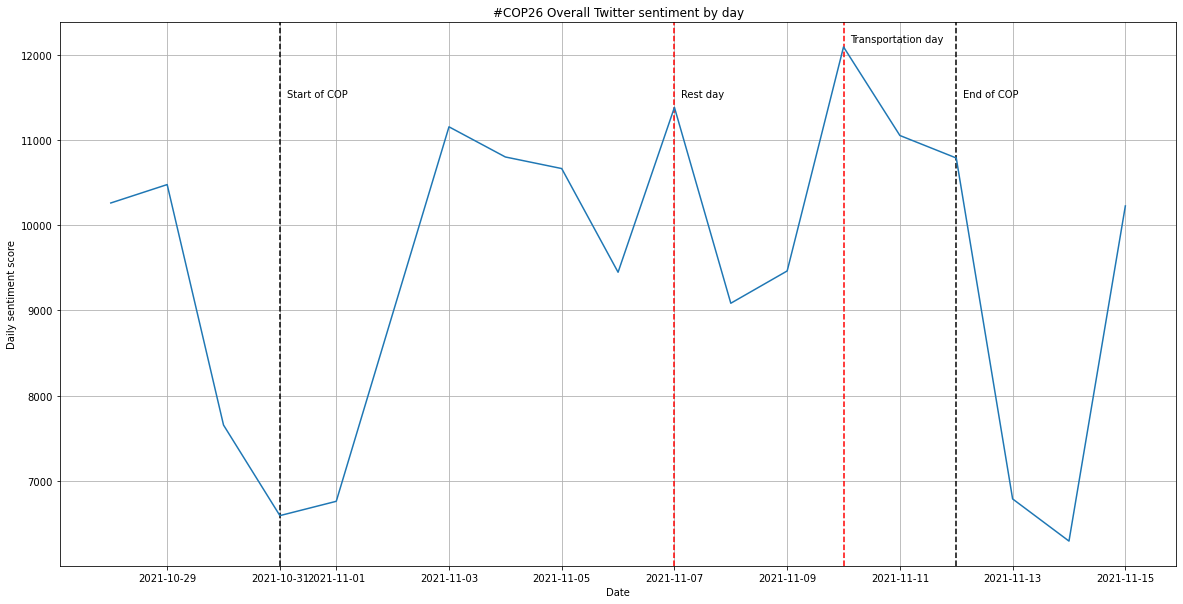

In [153]:
# Plantbasedtreaty    
#x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
x = [datetime.datetime(2021,10,28),datetime.datetime(2021,10,29),datetime.datetime(2021,10,30),
     datetime.datetime(2021,10,31),datetime.datetime(2021,11,1),datetime.datetime(2021,11,2),
     datetime.datetime(2021,11,3),datetime.datetime(2021,11,4),datetime.datetime(2021,11,5),
     datetime.datetime(2021,11,6),datetime.datetime(2021,11,7),datetime.datetime(2021,11,8),
     datetime.datetime(2021,11,9),datetime.datetime(2021,11,10),datetime.datetime(2021,11,11),
     datetime.datetime(2021,11,12),datetime.datetime(2021,11,13),datetime.datetime(2021,11,14),
     datetime.datetime(2021,11,15)]

y = anothergoddamnlist
plt.figure(figsize=(20,10))
plt.grid()

xcoords = [datetime.datetime(2021,11,7), datetime.datetime(2021,11,10)]
for xc in xcoords:
    plt.axvline(x=xc, color='r', linestyle='dashed')

confcoords = [datetime.datetime(2021,10,31), datetime.datetime(2021,11,12)]
for xc in confcoords:
    plt.axvline(x=xc, color='black', linestyle='dashed')    
    
    
#plt.xlim(
#    xmin=datetime.datetime(2021, 10, 28), # the one that doesn't change
#    xmax=datetime.datetime(2021, 11, 15) # the latest datetime in your dataset
plt.plot(x, y)
#sample_dates = np.array([datetime.datetime(11,7), datetime.datetime(11,10)])
#plt.vlines(x=sample_dates, ymin=0, ymax=12092, linestyles="dashed", color = 'r')
#fig, ax = plt.subplots()
#ax.set_xlim([datetime.date(2021, 10, 28), datetime.date(2021, 11, 15)])

plt.annotate("Start of COP", (datetime.datetime(2021,10,31, hour=3), 11500))
plt.annotate("End of COP", (datetime.datetime(2021,11,12, hour=3), 11500))

plt.annotate("Rest day", (datetime.datetime(2021,11,7, hour=3), 11500))
plt.annotate("Transportation day", (datetime.datetime(2021,11,10, hour=3), 12150))

plt.xlabel("Date")
plt.ylabel("Daily sentiment score")
plt.title('#COP26 Overall Twitter sentiment by day')
plt.show()
# plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
#             11, 12, 13, 14, 15, 16, 17, 18, 19], ["10/28", "10/29", "10/30",
#                                                   "10/31", "11/01", "11/02",
#                                                  "11/03","11/04","11/05",
#                                                  "11/06","11/07","11/08",
#                                                  "11/09","11/10","11/11",
#                                                  "11/12","11/13","11/14","11/15",])


Issues:
Forgot to pull tweets for the three days after the conference. Would have been nice to see the aftermath in the same way that we could see the three days before the conference. 


Interesting! Sentiment appears high in the days leading up to the conference, ping-pongs around a bit during, craters into a low during the four days leading up to the final day on 11/15, and then rebounds on the final day — signalling some optimism as things come to a close?

Two spikes during the conference:
11/7 - on the rest day. lol
11/10 - Transport: Driving the global transition to zero emission transport. Can't explain that intuitively.

#### Schedule


Sunday 31 October - Procedural opening of negotiations

Monday and Tuesday 1-2 November - World leaders summit: A two-day event welcoming heads of state and inviting them to put forward their ambitions and proposals towards securing global net zero carbon emissions, keeping the 1.5C temperature increase target within reach, protecting ecosystems and mobilising finance

Wednesday 3 November - Finance: Mobilising public and private finance flows at scale for mitigation and adaptation

Thursday 4 November - Energy: Accelerating the global transition to clean energy

Friday 5 November - Youth and public empowerment: Elevating the voice of young people and demonstrating the critical role of public empowerment and education in climate action

Saturday 6 November - Nature: Ensuring the importance of nature and sustainable land use are part of global action on climate change and a clean, green recovery

Sunday 7 November - Rest day

Monday 8 November - Adaptation, loss and damage: Delivering the practical solutions solutions needed to adapt to climate impact and address loss and damage

Tuesday 9 November - Gender: Progressing gender equality and the full and meaningful participation of women and girls in climate action
Science and innovation: Demonstrating that research and technology can deliver climate solutions to meet, and accelerate, increased ambition

Wednesday 10 November - Transport: Driving the global transition to zero emission transport

Thursday 11 November - Cities, Regions and Built Environment: Advancing action in the places we live, from communities, through to cities and regions
Friday 12 November - Closure of negotiations


Now, break down tweets by LDA topic modeling

Categorize tweets by topic

Plot daily sentiment by those 6 or so most interesting topics

In [156]:
for_modeling_unclean = db.full_text.dropna()
for_modeling = []

for tweet in for_modeling_unclean :
    words = [w for w in tweet.split()]# if w not in cop_sw]
    words = " ".join(words)    
    for_modeling.append(words)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [157]:
random.seed(1234)
for_modeling = sample(for_modeling, 1000)  
# take a sample of n to test modeller / just for speed if results are close to full corpus

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [158]:
# Updates spaCy's default stop words list with my additional words. 
stop_list = ['`',"Mr.","Mrs.","Ms."]
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [159]:
program_start = time.time()

doc_list = []
allowed_postags=['NOUN','ADJ','VERB','ADV']

# Iterates through each article in the corpus.
for doc in for_modeling :
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc)
    doc_list.append([token.lemma_ for token in pr if token.pos_ in allowed_postags])
    
program_end = time.time()
print('Total time taken to run is {} minutes.'.format(round(program_end - program_start)/60, 2))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total time taken to run is 0.3 minutes.


In [160]:
id2word = Dictionary(doc_list)  
id2word.filter_extremes(no_below=10, no_above=0.4)  #getting rid of fewer than 10 instances. 
                                # And no more than words that appear in a certain fraction
                                # of the total corpus size (in this case .4)
id2word.compactify()  # assign new word ids to all words. 
corpus = [id2word.doc2bow(word) for word in doc_list]


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [165]:
num_topics = 3

program_start = time.time()

lda_model = LdaMulticore(corpus=corpus, 
                             id2word=id2word, 
                             num_topics=num_topics, 
                             random_state=1,
                             chunksize=30,
                             passes=10,
                             alpha=0.31,  # sets our priors
                             eta=0.91,
                             eval_every=1,
                             per_word_topics=True,
                             workers=1)

program_end = time.time()
print('Total time taken to run is {} minutes.'.format(round(program_end - program_start)/60, 2))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total time taken to run is 0.13333333333333333 minutes.


In [166]:
pprint(lda_model.print_topics(num_words=20))

[(0,
  '0.035*"make" + 0.033*"end" + 0.031*"fuel" + 0.026*"fossil" + 0.020*"keep" + '
  '0.019*"tax" + 0.019*"coal" + 0.018*"watch" + 0.018*"new" + '
  '0.018*"government" + 0.017*"want" + 0.017*"get" + 0.016*"go" + '
  '0.016*"world" + 0.015*"carbon" + 0.014*"leader" + 0.014*"stop" + '
  '0.013*"need" + 0.012*"phase" + 0.011*"ask"'),
 (1,
  '0.079*"climate" + 0.032*"change" + 0.030*"need" + 0.027*"have" + '
  '0.025*"country" + 0.023*"now" + 0.021*"do" + 0.020*"’" + 0.020*"more" + '
  '0.018*"global" + 0.016*"action" + 0.015*"world" + 0.014*"time" + '
  '0.013*"leader" + 0.012*"emission" + 0.012*"so" + 0.012*"say" + 0.012*"take" '
  '+ 0.011*"help" + 0.011*"people"'),
 (2,
  '0.049*"cop26glasgow" + 0.038*"see" + 0.027*"auspol" + 0.027*"unknown" + '
  '0.025*"just" + 0.024*"hope" + 0.022*"work" + 0.021*"️" + 0.020*"week" + '
  '0.020*"here" + 0.019*"thank" + 0.018*"sure" + 0.017*"yesscot" + '
  '0.017*"many" + 0.017*"say" + 0.017*"ft" + 0.016*"✈" + 0.016*"meet" + '
  '0.016*"🔊" + 0.015

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [167]:
pyLDAvis.enable_notebook()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [168]:
#pyLDAvis.gensim.prepare(lda_model, corpus, words)
pyLDAvis.gensim_models.prepare(lda_model, corpus,id2word)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.104806  0.154821       1        1  49.430042
0     -0.104003 -0.155218       2        1  29.384354
2      0.208809  0.000398       3        1  21.185604, topic_info=             Term        Freq       Total Category  logprob  loglift
10        climate  239.000000  239.000000  Default  30.0000  30.0000
29   cop26glasgow   65.000000   65.000000  Default  29.0000  29.0000
181           see   52.000000   52.000000  Default  28.0000  28.0000
23           make   68.000000   68.000000  Default  27.0000  27.0000
50            end   61.000000   61.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
152         thing   13.802278   20.603691   Topic3  -4.5366   1.1512
89            say   21.762679   63.361599   Topic3  -4.0812   0.4832
8            hear   17.131181   35.477092   Topic3  -4.3205   0.8239
109          most   14.385979   26.870044   Topic3  -4.4952   0.9271
24         people   15.686070   59.322526   Topic3  -4.4086   0.2216

[155 rows x 6 columns], token_table=      Topic      Freq Term
term                      
20        1  0.927525    %
20        2  0.031984    %
20        3  0.031984    %
119       1  0.906348  act
119       2  0.043159  act
...     ...       ...  ...
70        2  0.035037    ️
70        3  0.945992    ️
71        1  0.045997    🔊
71        2  0.045997    🔊
71        3  0.919935    🔊

[354 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [169]:
# create temp lists to pass into dataframe
tweetlist = []
categorylist = []
probabilitylist = []
topic_assignments = []


# Calculate topic probabilities for each tweet & assign tweets to categories
for tweet in for_modeling :
    doc = [w for w in tweet.split()]
    pr = nlp(" ".join(doc))
    doc = [token.lemma_ for token in pr if token.pos_ in allowed_postags]
    doc_new = id2word.doc2bow(doc)

    topic_probs = lda_model[doc_new][0]
    topic = max(topic_probs,key=lambda x: x[1])
    topic_assignments.append(topic[0])    
    prob = max(topic_probs)
    cat = topic[0]
    prob = topic[1]
    tweetlist.append(tweet)
    categorylist.append(cat)
    probabilitylist.append(prob)

tweets_df = pd.DataFrame()
tweets_df["Tweet"] = tweetlist
tweets_df["Category"] = categorylist
tweets_df["Probability"] = probabilitylist

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


####  How do you bring the modeled tweets back together with their respective dates?

In [170]:
tweets_df

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Tweet,Category,Probability
0,"In case you missed it, we collaborated with @I...",1,0.888770
1,@AlokSharma_RDG &amp; @GretaThunberg Have you ...,2,0.562705
2,@MrKRudd @TurnbullMalcolm @abcnews @ABCscience...,1,0.718271
3,#cop26 How many #greenhydrogen announcements w...,2,0.686538
4,CFM Dallas Shares The Beauty Of Jesus Christ A...,0,0.656967
...,...,...,...
995,100+ countries formed a pact at #COP26 to end ...,1,0.761943
996,November News Cup COP 2-6 COVID 1-9 A draw #CO...,0,0.333333
997,@JoeBiden this falls on your watch. #COP26 #Fo...,0,0.677118
998,Disappointing outcome from #COP26. More needs ...,1,0.871191


In [173]:
db

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,user_id,screen_name,description,location,friends_count,followers_count,totaltweets,date_created,tweet_id,retweetcount,full_text,Unnamed: 0
0,581106535,jHIllionaire,NaN,"Little Rock, AR",992,346,392,2021-10-28 23:59:57+00:00,1453874206224101390,0,ANOTHER SENATOR PAID OFF! SEC NOT BANNING PFOF...,NaN
1,404386400,AndyFCDO,FCDO Adviser and M&E Lead for our regional dev...,Barbados,159,300,279,2021-10-28 23:59:34+00:00,1453874109826412575,1,Interesting piece on how COP26’s host - the ci...,NaN
2,4357271,gmh_upsa,This is what I stand for: “There is nothing so...,"Santo Domingo, Rep.Dominicana",3837,1365,32502,2021-10-28 23:59:33+00:00,1453874106030563328,2,@YoQPagoTolaLu @FPRI @JosephdeWeck @SibillaBon...,NaN
3,993968890500788225,GlasgowlovesEu,Non-partisan Glasgow-based group working for r...,Glasgow,5001,4198,23082,2021-10-28 23:59:07+00:00,1453873999881121818,4,The world’s first hydrogen bus arrives in Glas...,NaN
4,19381546,AliceAnnKuder,"Entrepreneur, writer, Realtor, canine guardian.",Seattle,159,144,3232,2021-10-28 23:58:59+00:00,1453873963591815170,0,Empty promises on climate have failed us. With...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
285079,2338181660,louisajanemoss,Everything is connected,"Dublin City, Ireland",5306.0,5492.0,7844.0,2021-11-15 17:30:34+00:00,1460299198658756608.0,1.0,#WeCanChange when @RubyMossMusic was 12\nHave ...,NaN
285080,242475822,sab_property,"Saint Andrews Bureau is a #lettings, #estatema...",NaN,321.0,315.0,2941.0,2021-11-15 17:30:33+00:00,1460299192908275712.0,0.0,"As #COP26 continues, research by HomeViews has...",NaN
285081,88697269,ENGIEgroup,ENGIE is a leading world group that provides l...,"Hauts-de-Seine, Ile-de-France",3285.0,65537.0,14427.0,2021-11-15 17:30:22+00:00,1460299147689480192.0,1.0,"#COP26 is over!\nAfter the debates, the countr...",NaN
285082,266628437,TheNHIC,"Membership organisation for the UK's repair, m...",Nationwide,569.0,1337.0,10377.0,2021-11-15 17:30:20+00:00,1460299137719713792.0,0.0,👂#listennow \n\nWant to hear about the home of...,NaN


In [194]:
newdf = tweets_df.merge(db, left_on='Tweet', right_on='full_text', how='inner')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [195]:
newdf2 = newdf.drop_duplicates(subset=['tweet_id'], keep='first')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [196]:
# rename columns from numbers to actual names for final display

newdf2['Category'] = newdf2['Category'].replace([0, 1, 2],
                                                            ['Policy', 'Action','Random'])


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-196-34ead37cd5e8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf2['Category'] = newdf2['Category'].replace([0, 1, 2],


In [197]:
actiondf = newdf2[newdf2['Category']=='Action']

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [199]:
policydf = newdf2[newdf2['Category']=='Policy']

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [200]:
randomdf = newdf2[newdf2['Category']=='Random']

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [201]:
# Subset dataframe to multiple 3-day windows

w1_text = actiondf.full_text[(actiondf['date_created']>= "2021-10-28") & (actiondf['date_created']< "2021-10-29")]
w2_text = actiondf.full_text[(actiondf['date_created']>= "2021-10-29") & (actiondf['date_created']< "2021-10-30")]
w3_text = actiondf.full_text[(actiondf['date_created']>= "2021-10-30") & (actiondf['date_created']< "2021-10-31")]
w4_text = actiondf.full_text[(actiondf['date_created']>= "2021-10-31") & (actiondf['date_created']< "2021-11-01")]
w5_text = actiondf.full_text[(actiondf['date_created']>= "2021-11-01") & (actiondf['date_created']< "2021-11-02")]
w6_text = actiondf.full_text[(actiondf['date_created']>= "2021-11-02") & (actiondf['date_created']< "2021-11-03")]
w7_text = actiondf.full_text[(actiondf['date_created']>= "2021-11-03") & (actiondf['date_created']< "2021-11-04")]
w8_text = actiondf.full_text[(actiondf['date_created']>= "2021-11-04") & (actiondf['date_created']< "2021-11-05")]
w9_text = actiondf.full_text[(actiondf['date_created']>= "2021-11-05") & (actiondf['date_created']< "2021-11-06")]
w10_text = actiondf.full_text[(actiondf['date_created']>= "2021-11-06") & (actiondf['date_created']< "2021-11-07")]
w11_text = actiondf.full_text[(actiondf['date_created']>= "2021-11-07") & (actiondf['date_created']< "2021-11-08")]
w12_text = actiondf.full_text[(actiondf['date_created']>= "2021-11-08") & (actiondf['date_created']< "2021-11-09")]
w13_text = actiondf.full_text[(actiondf['date_created']>= "2021-11-09") & (actiondf['date_created']< "2021-11-10")]
w14_text = actiondf.full_text[(actiondf['date_created']>= "2021-11-10") & (actiondf['date_created']< "2021-11-11")]
w15_text = actiondf.full_text[(actiondf['date_created']>= "2021-11-11") & (actiondf['date_created']< "2021-11-12")]
w16_text = actiondf.full_text[(actiondf['date_created']>= "2021-11-12") & (actiondf['date_created']< "2021-11-13")]
w17_text = actiondf.full_text[(actiondf['date_created']>= "2021-11-13") & (actiondf['date_created']< "2021-11-14")]
w18_text = actiondf.full_text[(actiondf['date_created']>= "2021-11-14") & (actiondf['date_created']< "2021-11-15")]
w19_text = actiondf.full_text[(actiondf['date_created']>= "2021-11-15") & (actiondf['date_created']< "2021-11-16")]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [202]:
# Subset dataframe to multiple 3-day windows

pw1_text = policydf.full_text[(policydf['date_created']>= "2021-10-28") & (policydf['date_created']< "2021-10-29")]
pw2_text = policydf.full_text[(policydf['date_created']>= "2021-10-29") & (policydf['date_created']< "2021-10-30")]
pw3_text = policydf.full_text[(policydf['date_created']>= "2021-10-30") & (policydf['date_created']< "2021-10-31")]
pw4_text = policydf.full_text[(policydf['date_created']>= "2021-10-31") & (policydf['date_created']< "2021-11-01")]
pw5_text = policydf.full_text[(policydf['date_created']>= "2021-11-01") & (policydf['date_created']< "2021-11-02")]
pw6_text = policydf.full_text[(policydf['date_created']>= "2021-11-02") & (policydf['date_created']< "2021-11-03")]
pw7_text = policydf.full_text[(policydf['date_created']>= "2021-11-03") & (policydf['date_created']< "2021-11-04")]
pw8_text = policydf.full_text[(policydf['date_created']>= "2021-11-04") & (policydf['date_created']< "2021-11-05")]
pw9_text = policydf.full_text[(policydf['date_created']>= "2021-11-05") & (policydf['date_created']< "2021-11-06")]
pw10_text = policydf.full_text[(policydf['date_created']>= "2021-11-06") & (policydf['date_created']< "2021-11-07")]
pw11_text = policydf.full_text[(policydf['date_created']>= "2021-11-07") & (policydf['date_created']< "2021-11-08")]
pw12_text = policydf.full_text[(policydf['date_created']>= "2021-11-08") & (policydf['date_created']< "2021-11-09")]
pw13_text = policydf.full_text[(policydf['date_created']>= "2021-11-09") & (policydf['date_created']< "2021-11-10")]
pw14_text = policydf.full_text[(policydf['date_created']>= "2021-11-10") & (policydf['date_created']< "2021-11-11")]
pw15_text = policydf.full_text[(policydf['date_created']>= "2021-11-11") & (policydf['date_created']< "2021-11-12")]
pw16_text = policydf.full_text[(policydf['date_created']>= "2021-11-12") & (policydf['date_created']< "2021-11-13")]
pw17_text = policydf.full_text[(policydf['date_created']>= "2021-11-13") & (policydf['date_created']< "2021-11-14")]
pw18_text = policydf.full_text[(policydf['date_created']>= "2021-11-14") & (policydf['date_created']< "2021-11-15")]
pw19_text = policydf.full_text[(policydf['date_created']>= "2021-11-15") & (policydf['date_created']< "2021-11-16")]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [203]:
# Subset dataframe to multiple 3-day windows

rw1_text = randomdf.full_text[(randomdf['date_created']>= "2021-10-28") & (randomdf['date_created']< "2021-10-29")]
rw2_text = randomdf.full_text[(randomdf['date_created']>= "2021-10-29") & (randomdf['date_created']< "2021-10-30")]
rw3_text = randomdf.full_text[(randomdf['date_created']>= "2021-10-30") & (randomdf['date_created']< "2021-10-31")]
rw4_text = randomdf.full_text[(randomdf['date_created']>= "2021-10-31") & (randomdf['date_created']< "2021-11-01")]
rw5_text = randomdf.full_text[(randomdf['date_created']>= "2021-11-01") & (randomdf['date_created']< "2021-11-02")]
rw6_text = randomdf.full_text[(randomdf['date_created']>= "2021-11-02") & (randomdf['date_created']< "2021-11-03")]
rw7_text = randomdf.full_text[(randomdf['date_created']>= "2021-11-03") & (randomdf['date_created']< "2021-11-04")]
rw8_text = randomdf.full_text[(randomdf['date_created']>= "2021-11-04") & (randomdf['date_created']< "2021-11-05")]
rw9_text = randomdf.full_text[(randomdf['date_created']>= "2021-11-05") & (randomdf['date_created']< "2021-11-06")]
rw10_text = randomdf.full_text[(randomdf['date_created']>= "2021-11-06") & (randomdf['date_created']< "2021-11-07")]
rw11_text = randomdf.full_text[(randomdf['date_created']>= "2021-11-07") & (randomdf['date_created']< "2021-11-08")]
rw12_text = randomdf.full_text[(randomdf['date_created']>= "2021-11-08") & (randomdf['date_created']< "2021-11-09")]
rw13_text = randomdf.full_text[(randomdf['date_created']>= "2021-11-09") & (randomdf['date_created']< "2021-11-10")]
rw14_text = randomdf.full_text[(randomdf['date_created']>= "2021-11-10") & (randomdf['date_created']< "2021-11-11")]
rw15_text = randomdf.full_text[(randomdf['date_created']>= "2021-11-11") & (randomdf['date_created']< "2021-11-12")]
rw16_text = randomdf.full_text[(randomdf['date_created']>= "2021-11-12") & (randomdf['date_created']< "2021-11-13")]
rw17_text = randomdf.full_text[(randomdf['date_created']>= "2021-11-13") & (randomdf['date_created']< "2021-11-14")]
rw18_text = randomdf.full_text[(randomdf['date_created']>= "2021-11-14") & (randomdf['date_created']< "2021-11-15")]
rw19_text = randomdf.full_text[(randomdf['date_created']>= "2021-11-15") & (randomdf['date_created']< "2021-11-16")]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [204]:
actiontweets = [w1_text, w2_text, w3_text, w4_text, w5_text, w6_text, w7_text, w8_text, w9_text, w10_text,
              w11_text, w12_text, w13_text, w14_text, w15_text, w16_text, w17_text, w18_text, w19_text]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [205]:
randomtweets = [rw1_text, rw2_text, rw3_text, rw4_text, rw5_text, rw6_text, rw7_text, rw8_text, rw9_text, rw10_text,
              rw11_text, rw12_text, rw13_text, rw14_text, rw15_text, rw16_text, rw17_text, rw18_text, rw19_text]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [206]:
policyweets = [pw1_text, pw2_text, pw3_text, pw4_text, pw5_text, pw6_text, pw7_text, pw8_text, pw9_text, pw10_text,
              pw11_text, pw12_text, pw13_text, pw14_text, pw15_text, pw16_text, pw17_text, pw18_text, pw19_text]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [218]:
actionscores = []

for item in actiontweets:
    score = sentiment_bywindow(item)
    actionscores.append(score)
    
actionlist = []

for item in actionscores:
    actionlist.append(item[0])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [219]:
randomscores = []

for item in randomtweets:
    score = sentiment_bywindow(item)
    randomscores.append(score)
    
randomlist = []

for item in randomscores:
    randomlist.append(item[0])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [220]:
policyscores = []

for item in policyweets:
    score = sentiment_bywindow(item)
    policyscores.append(score)
    
policylist = []

for item in policyscores:
    policylist.append(item[0])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


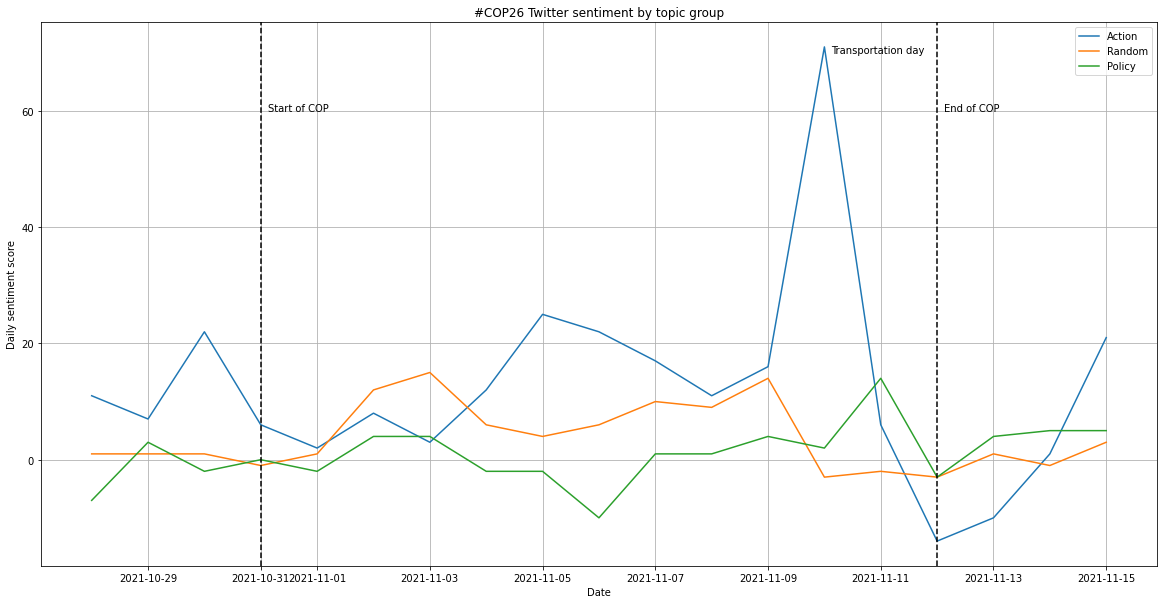

In [231]:
# Plantbasedtreaty    
#x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
x = [datetime.datetime(2021,10,28),datetime.datetime(2021,10,29),datetime.datetime(2021,10,30),
     datetime.datetime(2021,10,31),datetime.datetime(2021,11,1),datetime.datetime(2021,11,2),
     datetime.datetime(2021,11,3),datetime.datetime(2021,11,4),datetime.datetime(2021,11,5),
     datetime.datetime(2021,11,6),datetime.datetime(2021,11,7),datetime.datetime(2021,11,8),
     datetime.datetime(2021,11,9),datetime.datetime(2021,11,10),datetime.datetime(2021,11,11),
     datetime.datetime(2021,11,12),datetime.datetime(2021,11,13),datetime.datetime(2021,11,14),
     datetime.datetime(2021,11,15)]

y = actionlist
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(x, y, label="Action")

x2 = x
y2 = randomlist
plt.plot(x2, y2, label="Random")

x3 = x
y3 = policylist
plt.plot(x3, y3, label="Policy")










# xcoords = [datetime.datetime(2021,11,10)]
# for xc in xcoords:
#     plt.axvline(x=xc, color='r', linestyle='dashed')

confcoords = [datetime.datetime(2021,10,31), datetime.datetime(2021,11,12)]
for xc in confcoords:
    plt.axvline(x=xc, color='black', linestyle='dashed')    
    
    
#plt.xlim(
#    xmin=datetime.datetime(2021, 10, 28), # the one that doesn't change
#    xmax=datetime.datetime(2021, 11, 15) # the latest datetime in your dataset
#sample_dates = np.array([datetime.datetime(11,7), datetime.datetime(11,10)])
#plt.vlines(x=sample_dates, ymin=0, ymax=12092, linestyles="dashed", color = 'r')
#fig, ax = plt.subplots()
#ax.set_xlim([datetime.date(2021, 10, 28), datetime.date(2021, 11, 15)])

plt.annotate("Start of COP", (datetime.datetime(2021,10,31, hour=3), 60))
plt.annotate("End of COP", (datetime.datetime(2021,11,12, hour=3), 60))

#plt.annotate("Rest day", (datetime.datetime(2021,11,7, hour=3), 60))
plt.annotate("Transportation day", (datetime.datetime(2021,11,10, hour=3), 70))

plt.xlabel("Date")
plt.ylabel("Daily sentiment score")
plt.title('#COP26 Twitter sentiment by topic group')
plt.legend()
plt.show()
# plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
#             11, 12, 13, 14, 15, 16, 17, 18, 19], ["10/28", "10/29", "10/30",
#                                                   "10/31", "11/01", "11/02",
#                                                  "11/03","11/04","11/05",
#                                                  "11/06","11/07","11/08",
#                                                  "11/09","11/10","11/11",
#                                                  "11/12","11/13","11/14","11/15",])
